# Rossman Store Sales Compatition

This notebook contains a brief description of the analysis done and the final model.


## Table of Contents

1. [Data Processing](#data-pre-processing)
    * [Load raw sales data](#load-data)
    * [Add features: months, weeks](#features-months-weeks)
    * [Add features: beggining and end of month](#features-beginning-end-month)
    * [Clean data](#clean-data)
    * [Add features: store info](#features-store-info)
2. [Model Training](#model-training)
    * [Prepare train/test data](#prepare-train-test)
    * [Feature encoding](#feature-encoding)
    * [Feature scaling](#feature-scaling)
    * [Models](#models)
    * [Processing pipeline](#processing-pipeline)
3. [Model Selection](#model-selection)
    * [Hyperparameter optimization](#hyperparameter-optimization)
    * [Final training](#final-training)
    * [Saving the model](#saving-model)
4. [Model Evaluation](#model-evaluation)


## Data Processing <a class="anchor" id="data-pre-processing"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.dpi']=150
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime

# Load scripts from parent path
import sys, os
sys.path.insert(0, os.path.abspath('..'))

### Load raw sales data <a class="anchor" id="load-data"></a>

This table contains the raw daily sales by Rossmann store.

The target column is:
  - `Sales`: The total sum of sales for this store and date

The features columns are:
  - `Date`: The date of the sales record
  - `Store`: An ID of the store
  - `DayOfWeek`: The day of the week, given as an integer, ranging from Monday (0) to Sunday (6).
  - `Customers`: The number of customers for this store and date. We will drop this, as this information is not available for the future.
  - `Open`: Whether the store was open on this date: 0 = closed, 1 = open
  - `Promo`: Whether the store ran a promotion on this date.
  - `StateHoliday`: Whether this date was a state holiday.
  - `SchoolHoliday`: Whether this date was a school holiday.

The training data includes data for one and a half years, from 2013-01-01 until 2014-07-31.

The holdout (test) period is the following 6 months, from 2014-08-01 to 2015-07-31.


In [2]:
import scripts.processing as scr

train_raw = scr.load_train_data()
train_raw.head()

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


,Date,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,2013-01-01,1115.0,2.0,0.0,0.0,0.0,0.0,a,1.0
1,2013-01-01,379.0,2.0,0.0,0.0,0.0,0.0,a,1.0
2,2013-01-01,378.0,2.0,0.0,0.0,0.0,0.0,a,1.0
3,2013-01-01,377.0,2.0,0.0,0.0,0.0,0.0,a,1.0
4,2013-01-01,376.0,2.0,0.0,0.0,0.0,0.0,a,1.0


**Plot sales**

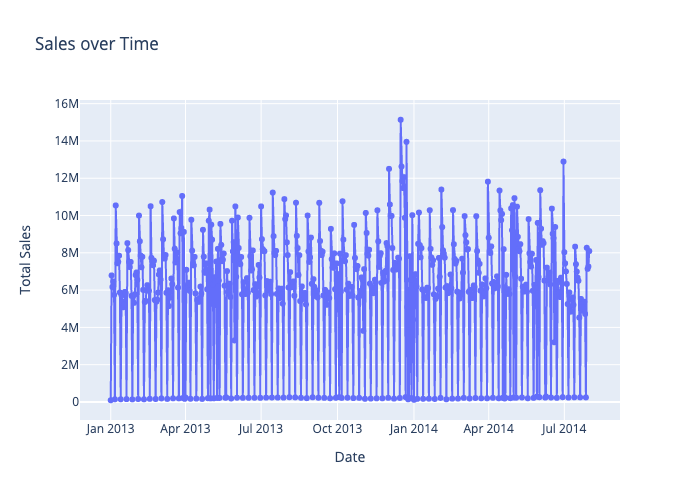

In [3]:
sales = train_raw.groupby(by='Date').agg({'Sales': 'sum'}).reset_index()

fig = go.Figure()
fig.add_trace(go.Scatter(x=sales['Date'], y=sales['Sales'],
                    mode='lines+markers',
                    name='actual'))
fig.update_layout(title='Sales over Time',
                   xaxis_title='Date',
                   yaxis_title='Total Sales')
fig.show('png')

### Add features: months, weeks <a class="anchor" id="features-months-weeks"></a>

The `Date`-column in itself is not informative, as our prediction should
extrapolate in the future. However, features of the date can be extracted.

To captures seasonal trends in sales, we added the features:
- `month`: The month of the year.
- `week`: The week of the year.

Note: The functions used here (such as `add_week_month_info`) are also implemented in `scripts.processing`, we
repeat them here just for illustration.

In [4]:
def add_week_month_info(train):
    """
    Add week and month information as another column to the features.
    """
    train.loc[:,'week'] = train.loc[:,'Date'].dt.isocalendar().week.astype(int)
    train.loc[:,'month'] = train.loc[:,'Date'].dt.month
    return train

train = add_week_month_info(train_raw)
train.loc[:, ['week', 'month']].head()

,week,month
0,1,1
1,1,1
2,1,1
3,1,1
4,1,1


### Add features: Beggining and end of month signifiers <a class="anchor" id="features-beginning-end-month"></a>

After our first round of modeling, we found that the errors/residuals of our models were very high towards the beginning and end of months (see analysis in the end of this notebook).

This could indicate that sales patterns are different at the beginning and
end of months (for example if people receive their paycheck with
some regularity).

To enable our model to learn these patterns, we decided to add features that
signify the beginning and end of months:
- `beginning_of_month`: Indicates whether the date is towards the *beginning* of the month, ranging from 0 (no) to 1 (yes).
- `end_of_month`: Indicates whether the date is towards the *end* of the month, ranging from 0 (no) to 1 (yes).


In [5]:
def add_beginning_end_month(train):
    """
    Add features that represent the beginning and end of months.
    """
    def get_feature_end_month(day_of_month):
        return (day_of_month/31)**4

    def get_feature_beginning_month(day_of_month):
        return ((31-day_of_month)/31)**4

    # get_feature_end_month(33)
    train.loc[:, 'end_of_month'] = train.loc[:, 'Date'].dt.day.apply(get_feature_end_month)
    train.loc[:, 'beginning_of_month'] = train.loc[:, 'Date'].dt.day.apply(get_feature_beginning_month)
    return train

train = add_beginning_end_month(train)
train.loc[:, ['Date', 'end_of_month', 'beginning_of_month']].head()

,Date,end_of_month,beginning_of_month
0,2013-01-01,0.000001,0.877078
1,2013-01-01,0.000001,0.877078
2,2013-01-01,0.000001,0.877078
3,2013-01-01,0.000001,0.877078
4,2013-01-01,0.000001,0.877078


**Visualization of beginning/end of month features**

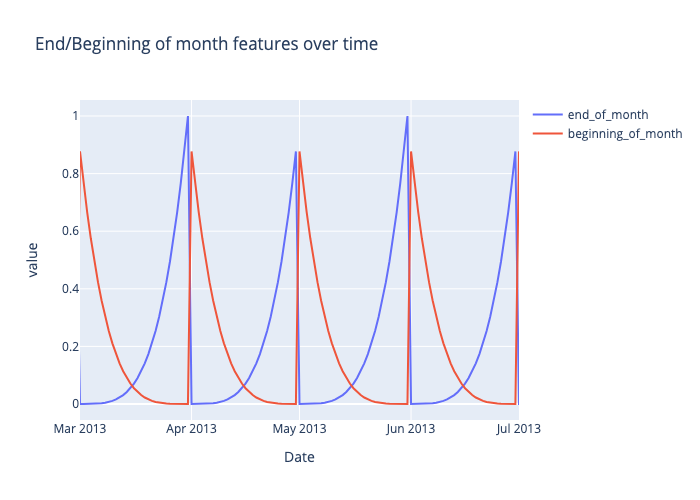

In [6]:
month_features = train.groupby(by='Date').agg({'end_of_month': 'first', 'beginning_of_month': 'first'}).reset_index()

fig = go.Figure()
fig.add_trace(go.Scatter(x=month_features['Date'], y=month_features['end_of_month'],
                    mode='lines',
                    name='end_of_month'))

fig.add_trace(go.Scatter(x=month_features['Date'], y=month_features['beginning_of_month'],
                    mode='lines',
                    name='beginning_of_month'))
                    
fig.update_layout(title='End/Beginning of month features over time',
                   xaxis_title='Date',
                   yaxis_title='value',
                   xaxis_range=[datetime(2013, 3, 1),
                               datetime(2013, 7, 1)])

fig.show('png')

### Clean data <a class="anchor" id="clean-data"></a>

We do some small data cleaning steps:
- Drop the `Customers` column, as this info will not be available in the future.
- Remove rows with sales that are null or 0.
- Drop the `Open` column - stores that have non-zero sales are open.
- Remove observations with null values in any feature.
- etc.

In [7]:
def clean_data(train_raw, drop_null=True, drop_date=True):
    """ Some common basic data processing. 
    
    This function
     - Encodes the state holidays
     - Drops unneeded columns (Customers, Open, Date)
     - Removes all rows where 'Sales' were 0
     - Removes all rows with nan values
    """
    train = train_raw.copy()
    train.loc[:, 'StateHoliday'] = train.loc[:, 'StateHoliday'].replace(to_replace='0', value='d')

    # Drop customers, open and Date
    train = train.drop(["Customers", "Open"], axis=1)
    if drop_date:
        train = train.drop("Date", axis=1)

    # Drop all where sales are nan or 0
    if 'Sales' in train.columns:
        train = train.dropna(axis=0, how='any', subset=['Sales'])
        train = train.loc[train.loc[:, 'Sales']!=0, :]

    # Drop all null value
    if drop_null:
        train = train.dropna(axis=0, how='any')

    return train

train = clean_data(train)

### Add features: Store info <a class="anchor" id="features-store-info"></a>

Some additional information on the stores was made available in the
file `data/store.csv`.

We combined this with the sales information and calculated some additional features.

(The full details are given in the notebook `util_extract_store_info`)

We added the following features:
 - `Store`: The ID of the store, for mapping to the sales data.
 - `StoreType`: The type of store, differing between four models, a, b, c, d.
 - `Assortment`: The type of goods that the store is carrying, a = basic, b = extra, c = extended.
 - `CompetitionDistance`: The distance to the nearest competing store, in meters.
 - `month`: The month for which average sales and customers were calculated.
 - `Store_Sales_mean`: The mean sales for this store and month.
 - `Store_Customers_mean`: The mean customers for this store and month.

In [8]:
store_info = pd.read_csv("../data/store_info.csv")
store_info.head()

,Store,StoreType,Assortment,CompetitionDistance,month,Store_Sales_mean,Store_Customers_mean
0,1,c,a,1270.0,1,3926.966102,487.442623
1,1,c,a,1270.0,2,4175.722222,508.716981
2,1,c,a,1270.0,3,4273.250000,517.338983
3,1,c,a,1270.0,4,3912.875000,471.948276
4,1,c,a,1270.0,5,3784.733333,454.762712


Merge the store info onto the sales table.

In [9]:
def add_store_info(train):
    """ Add the store info to sales data.

    Merges the store info on the train table and returns the combined table
    """
    # Load store info
    store_info = pd.read_csv("../data/store_info.csv")
    # Merge store info onto train data
    train = pd.merge(left=train, right=store_info, how='left', on=['Store', 'month'])
    return train

train = add_store_info(train)
train.loc[:, ['StoreType', 'Assortment',
              'CompetitionDistance', 'Store_Sales_mean',
              'Store_Customers_mean']].head()

,StoreType,Assortment,CompetitionDistance,Store_Sales_mean,Store_Customers_mean
0,b,b,900.0,4139.474576,1153.783333
1,b,a,90.0,12845.896552,2384.271186
2,b,b,590.0,3725.649123,888.627119
3,b,a,1260.0,7079.150000,1010.583333
4,a,c,18160.0,2260.783333,333.610169


## Model Training <a class="anchor" id="model-training"></a>

### Prepare train/test data <a class="anchor" id="prepare-train-test"></a>

The target label is `Sales`.

The features include all the other columns in the dataset.



In [10]:
train.head()

,Store,DayOfWeek,Sales,Promo,StateHoliday,SchoolHoliday,week,month,end_of_month,beginning_of_month,StoreType,Assortment,CompetitionDistance,Store_Sales_mean,Store_Customers_mean
0,353.0,2.0,3139.0,0.0,a,1.0,1,1,0.000001,0.877078,b,b,900.0,4139.474576,1153.783333
1,335.0,2.0,2401.0,0.0,a,1.0,1,1,0.000001,0.877078,b,a,90.0,12845.896552,2384.271186
2,512.0,2.0,2646.0,0.0,a,1.0,1,1,0.000001,0.877078,b,b,590.0,3725.649123,888.627119
3,494.0,2.0,3113.0,0.0,a,1.0,1,1,0.000001,0.877078,b,a,1260.0,7079.150000,1010.583333
4,530.0,2.0,2907.0,0.0,a,1.0,1,1,0.000001,0.877078,a,c,18160.0,2260.783333,333.610169


In [11]:
# Split label and features
X = train.copy(deep=True).drop(columns=["Sales"])
y = train.loc[:, "Sales"]

# Make train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

### Feature Encoding <a class="anchor" id="feature-encoding"></a>

We originally used one-hot encoding for certain features such as Assortment type, State holiday, Store type, ... but the final score for target encoding was better. Therefore, we chose to target encode any feature that needs to be encoded.

In [16]:
import category_encoders as ce
target_encode  = ce.TargetEncoder()

### Feature Scaling <a class="anchor" id="feature-scaling"></a>
We scaled the features, to have the same range. This step has a higher importance, when using linear regression models.

In [17]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

### Models <a class="anchor" id="models"></a>

In the first step, we tried a simple mean estimator as the baseline.

We then selected two models, Random Forest Regressor and Gradient Boosting Machine (LGBM). We compared the performance of the two models and LGBM was scoring better, hence was selected as our model of choice. 

In [18]:
from lightgbm import LGBMRegressor
model = LGBMRegressor()

### Processing pipeline <a class="anchor" id="processing-pipeline"></a>
We created a pipeline consisting of different processing steps: encoding, scaling and modeling

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
pipe = Pipeline(steps=[ 
                ('target_encode', target_encode),
                ('scaler',scaler),
                ('model',model)])                           

## Model Selection <a class="anchor" id="model-selection"></a>

### Hyperparameter optimization <a class="anchor" id="hyperparameter-optimization"></a>

In order to select the best hyperparameters for our pipeline, we performed a grid search on a number of parameters. 
The hyperparameters corresponding the model that we explored were: n_estimators, max_depth, num_leaves.

Here, we only show the resulting best parameter set.

In [20]:
# parameters = {'model__n_estimators': [600, 900],
#               'model__max_depth': [15, 25, 25],
#               'model__num_leaves': [31, 50, 80, 100],
#              }
parameters = {'model__n_estimators': [900],
              'model__max_depth': [25],
              'model__num_leaves': [80],
             }

In [22]:
# Surpress some FutureWarnings that pop up form category_encoders
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


regLGBMGridSearch = GridSearchCV(pipe, parameters, cv=5, n_jobs=-1, verbose=1, error_score='raise')
grid_search = regLGBMGridSearch.fit(X_train, y_train) 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
/Users/frank/.local/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
  elif pd.api.types.is_categorical(cols):
/Users/frank/.local/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
  elif pd.api.types.is_categorical(cols):
/Users/frank/.local/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed

In [23]:
grid_search.best_estimator_

Pipeline(steps=[('target_encode',
                 TargetEncoder(cols=['StateHoliday', 'StoreType',
                                     'Assortment'])),
                ('scaler', StandardScaler()),
                ('model',
                 LGBMRegressor(max_depth=25, n_estimators=900, num_leaves=80))])

We iterated over the value of these parameters a couple of times and selected the best parameters. We looked at other parameters than can be tuned and in the next step and took various subsets of different features to target encode.

In [24]:
regLGBMGridSearch.estimator.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'target_encode', 'scaler', 'model', 'target_encode__cols', 'target_encode__drop_invariant', 'target_encode__handle_missing', 'target_encode__handle_unknown', 'target_encode__min_samples_leaf', 'target_encode__return_df', 'target_encode__smoothing', 'target_encode__verbose', 'scaler__copy', 'scaler__with_mean', 'scaler__with_std', 'model__boosting_type', 'model__class_weight', 'model__colsample_bytree', 'model__importance_type', 'model__learning_rate', 'model__max_depth', 'model__min_child_samples', 'model__min_child_weight', 'model__min_split_gain', 'model__n_estimators', 'model__n_jobs', 'model__num_leaves', 'model__objective', 'model__random_state', 'model__reg_alpha', 'model__reg_lambda', 'model__silent', 'model__subsample', 'model__subsample_for_bin', 'model__subsample_freq'])

**Hyperparameter search over Target Encodings**

In [25]:
parameters = {'model__n_estimators': [900],
              'model__max_depth': [25],
              'model__num_leaves': [80],
             'target_encode__cols':
             [
                ['Store','StoreType','Assortment','StateHoliday','week','month','beginning_of_month','end_of_month'],
                ['Store','StoreType','Assortment','StateHoliday','week','month'],
                ['Store','StoreType','Assortment']
            ]
             }

In [26]:
regLGBMGridSearch = GridSearchCV(pipe, parameters, cv=5, n_jobs=-1, verbose=1, error_score='raise')
grid_search = regLGBMGridSearch.fit(X_train, y_train) 

Fitting 5 folds for each of 3 candidates, totalling 15 fits


<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
/Users/frank/.local/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
  elif pd.api.types.is_categorical(cols):
/Users/frank/.local/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
  elif pd.api.types.is_categorical(cols):
/Users/frank/.local/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
  elif pd.api.types.is_categorical(cols):
/Users/frank/.local/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarnin

In [22]:
print("Best parameter (CV score=%0.3f):" % grid_search.best_score_)
grid_search.best_estimator_

Best parameter (CV score=0.940):


Pipeline(steps=[('target_encode',
                 TargetEncoder(cols=['Store', 'StoreType', 'Assortment'])),
                ('scaler', StandardScaler()),
                ('model',
                 LGBMRegressor(max_depth=25, n_estimators=900, num_leaves=80))])

### Model's performance on the test data
Finally, we evaluated the error using on the validation data set.

In [23]:
from scripts.processing import metric
y_pred = grid_search.best_estimator_.predict(X_test)
error_regLGBM = metric(y_test.values, y_pred)
print(f"RMSPE metric on test set: {error_regLGBM:.2f}")

10.83195215627002

### Final Training <a class="anchor" id="final-training"></a>

Finally, we used the best model and trained it once again on the total data to create the final model

In [24]:
best_model = grid_search.best_estimator_
best_model_wholeDataRefitted = best_model.fit(X,y)

In [25]:
best_model_wholeDataRefitted
y_pred = best_model_wholeDataRefitted.predict(X)

### Saving the model <a class="anchor" id="saving-model"></a>

We save the trained model so that it can be reused later.

In [26]:
from scripts.pipeline import save_pipeline
save_pipeline(pipeline=best_model_wholeDataRefitted, name='LGBM_hyperparam_optim_3')

 - Saving pipeline "LGBM_hyperparam_optim_3" at:
../data/trained_pipelines/pipeline_LGBM_hyperparam_optim_3.p


## Model Evaluation <a class="anchor" id="model-evaluation"></a>

We now load the final model, with was a Gradient Boosted Tree classifier.

In [14]:
import warnings
from scripts.pipeline import load_pipeline
# pipe = load_pipeline(name='LGBM_hyperparam_optim_3')
pipe = load_pipeline(name='LGBM_hyperparam_optim')
y_pred = pipe.predict(X)

 - Loading pipeline "LGBM_hyperparam_optim" at:
../data/trained_pipelines/pipeline_LGBM_hyperparam_optim.p


/Users/frank/miniforge3/envs/rossman-comp/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning:

Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations

/Users/frank/miniforge3/envs/rossman-comp/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning:

Trying to unpickle estimator Pipeline from version 0.23.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations

/Users/frank/miniforge3/envs/rossman-comp/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning:

X has feature names, but StandardScaler was fitted without feature names



### Score on test set 

In [15]:
from scripts.processing import metric
y_pred = pipe.predict(X_test)
error_regLGBM = metric(y_test.values, y_pred)
print(f"RMSPE metric on test set: {error_regLGBM:.2f}")

/Users/frank/miniforge3/envs/rossman-comp/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning:

X has feature names, but StandardScaler was fitted without feature names



RMSPE metric on test set: 10.06


### Compare daily sales

To better evaluate the model, we compare the daily sales
numbers predicted by our model and the actual daily sales

In [16]:
def metric_not_summed(preds, actuals):
    """ The RMSPE metric per observation """
    preds = preds.reshape(-1)
    actuals = actuals.reshape(-1)
    assert preds.shape == actuals.shape
    return 100 * (actuals - preds) / actuals

# Load the dates from the data
train_raw = scr.load_train_data()
dates = pd.DataFrame(scr.process_data(train_raw, drop_null=True, drop_date=False).loc[:, 'Date'])

# Merge predicted and actual values
result = dates.copy()
result = result.reset_index() #added step to solve the problem with keys and nan values in y_actual

result.loc[:, 'pred'] = y_pred  
result.loc[:, 'actual'] = y

# Sum up result by date
result = result.groupby(by='Date').sum().reset_index()

# Calculate the error
result.loc[:, 'error'] = metric_not_summed(result.loc[:, 'pred'].values, result.loc[:, 'actual'].values)
result.loc[:, 'error_abs'] = np.abs(result.loc[:, 'error'])
result.head()

ValueError: Length of values (44005) does not match length of index (440048)

,Date,index,pred,actual,error,error_abs
0,2013-01-01,7453,1.247358e+05,87980.0,-41.777470,41.777470
1,2013-01-02,1538235,5.706822e+06,5707185.0,0.006356,0.006356
2,2013-01-03,2521226,5.233531e+06,5177894.0,-1.074515,1.074515
3,2013-01-04,3657192,5.629987e+06,5627268.0,-0.048311,0.048311
4,2013-01-05,4645127,5.017485e+06,4960593.0,-1.146888,1.146888


In [32]:
import plotly.express as px
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=result['Date'], y=result['actual'],
                    mode='lines+markers',
                    name='actual'))

fig.add_trace(go.Scatter(x=result['Date'], y=result['pred'],
                    mode='lines',
                    name='predicted'))
# Edit the layout
fig.update_layout(title='Sales over Time - Prediction of Final Model vs. Actual',
                   xaxis_title='Date',
                   yaxis_title='Total Sales')
fig.show()

In [34]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=result['Date'], y=result['error'],
                    mode='markers',
                    name='actual'))

fig.update_layout(title='Error over Time',
                   xaxis_title='Date',
                   yaxis_title='Error')

fig.show()

### Feature importance

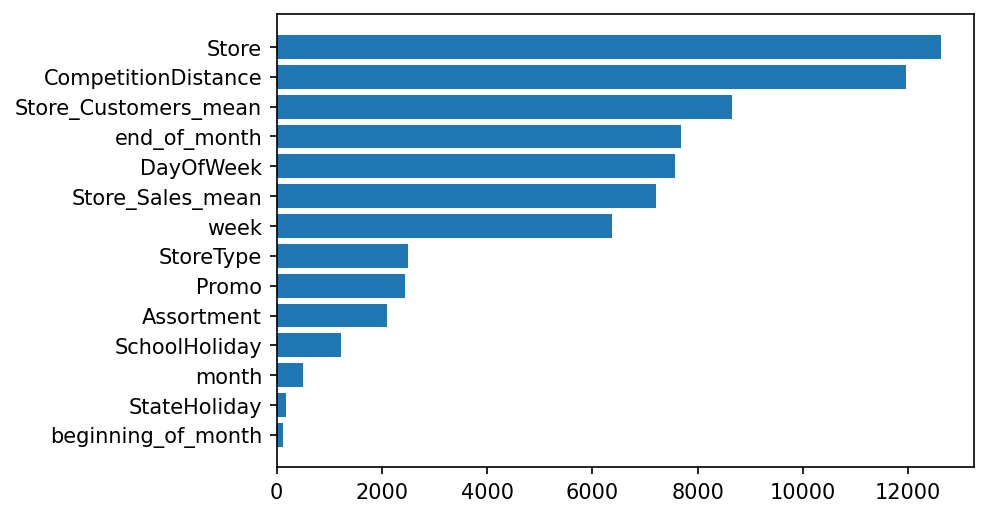

In [50]:
model = pipe['model']
importances = pd.DataFrame({'feature': pipe[1].get_feature_names_out(), 'importance': model.feature_importances_})
importances = importances.sort_values(by='importance', ascending=True)
plt.barh(y=importances['feature'], width=importances['importance'])
plt.show()